# Master Fusion Hands-on RF Directional Coupler and Travelling Wave Antenna

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab 
%matplotlib inline
import skrf as rf
rf.stylely()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


## Phase shifter

In the following, we analyse the scattering parameters of the phase shifter for all values of its indicator

In [3]:
idx_ps = np.linspace(0, 180, 19)  # indexes of the phase shifter, from 0 to 180 per 10

In [4]:
# creating a NetworkSet from the 19 measurements
Narda_dict = rf.read_all('Sparameters/2019-01-17_Mesures Julien/', 
                         contains='Narda_phase-shifter', f_unit='GHz')
Narda_ps = rf.NetworkSet(Narda_dict)

In [5]:
# get the measured phase shift at middle frequency 
phases = []
for ps in Narda_ps:
    phases.append(ps['1.5 GHz'].s21.s_deg)
phases = np.array(phases).squeeze()

(-180, 180)

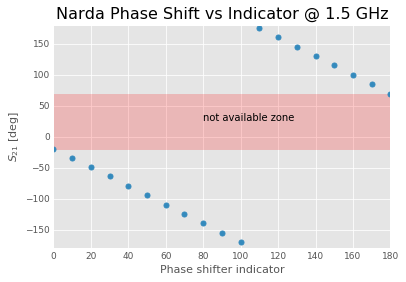

In [6]:
fig, ax = plt.subplots()
ax.plot(idx_ps, phases, '.', ms=10)
ax.set_xlabel('Phase shifter indicator')
ax.set_ylabel('$S_{21}$ [deg]')
ax.set_title('Narda Phase Shift vs Indicator @ 1.5 GHz')
ax.fill_between(idx_ps, phases[0], phases[-1], alpha=0.2, color='r')
ax.text(80, 25, 'not available zone')
phase_indexes = np.linspace(0, 180, 181)
ax.set_ylim(-180, 180)

In [7]:
# Creating an interpolation of the phase shifter using the 19 measurements performed
phase_indexes = np.linspace(0, 180, 181)

new_phase = []
for phase_index in phase_indexes:
    interpolated_ntw = Narda_ps.interpolate_from_network(idx_ps, phase_index)
    new_phase.append(interpolated_ntw['1.5GHz'].s21.s_deg)
new_phase = np.array(new_phase).squeeze()

In [8]:
s11_mes, s11_ntw = [], []

# Creating an interpolation of the phase shifter using the 19 measurements performed
phase_indexes = np.linspace(0, 180, 181)

for ps in Narda_ps:
    s11_mes.append(ps['1.5GHz'].s11.s_db)

for phase_index in phase_indexes:
    interpolated_ntw = Narda_ps.interpolate_from_network(idx_ps, phase_index, interp_kind='linear')
    s11_ntw.append(interpolated_ntw['1.5GHz'].s11.s_db)

s11_mes = np.array(s11_mes).squeeze()
s11_ntw = np.array(s11_ntw).squeeze()

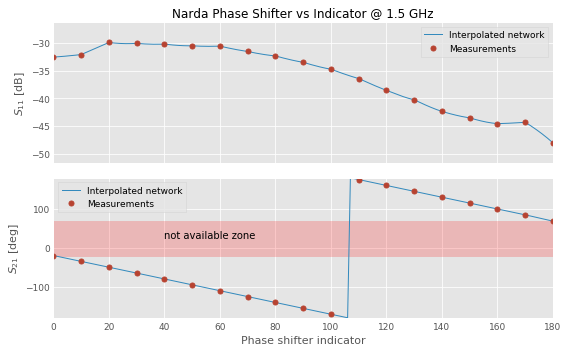

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=True)
ax1.set_title('Narda Phase Shifter vs Indicator @ 1.5 GHz', fontsize=12)


ax1.plot(phase_indexes, s11_ntw, label='Interpolated network')
ax1.plot(idx_ps, s11_mes, '.', ms=10, label='Measurements')
ax1.legend()
ax1.set_ylabel(r'$S_{11}$ [dB]')

ax2.plot(phase_indexes, new_phase, label='Interpolated network')

ax2.plot(idx_ps, phases, '.', ms=10, label='Measurements')
ax2.set_xlabel('Phase shifter indicator')
ax2.set_ylabel('$S_{21}$ [deg]')

ax2.fill_between(idx_ps, phases[0], phases[-1], alpha=0.2, color='r')
ax2.text(40, 25, 'not available zone')
ax2.legend()
ax2.set_ylim(-180, 180)

fig.tight_layout()

In [10]:
fig.savefig('phase_shifter_interpolated_network.png', dpi=150)

## Variable Coupler

A variable coupling coefficient coupler is a coupler which the coupling coefficient can be adjusted. It is possible to create such a coupler using two hybrid couplers and a phase shifter, as illustrated by the figure below: 

![adjustable directional coupler](Figures/Adjustable_Coupler.png)

In [11]:
freq = rf.Frequency(start=1.5, stop=1.5, npoints=1, unit='GHz')
freq

1.5-1.5 GHz, 1 pts

In [12]:
coax = rf.media.DefinedGammaZ0(frequency=freq)
print(coax)

In [13]:
# create and return a phase shifter of a specific angle 
def phase_shifter(phase_deg):
    return coax.line(d=phase_deg, unit='deg')

In [14]:
"""
3 dB hybrid
              _________
Input     1 --|       |-- 2 Through
              |       |
Isolated  4 --|_______|-- 3 Coupled

"""
def hybrid(name='hybrid'):
    Sc = 1/sqrt(2)*np.array([[0,1,1j,0], 
                             [1,0,0,1j], 
                             [1j,0,0,1], 
                             [0,1j,1,0]])
    hybrid = rf.Network(frequency=freq, s=np.tile(Sc,len(freq)), name=name)
    return hybrid

print(hybrid())

4-Port Network: 'hybrid',  1.5-1.5 GHz, 1 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [15]:
def variable_coupler(phase_deg):
    ps = phase_shifter(phase_deg)
    hybrid1, hybrid2 = hybrid(), hybrid()
    _temp = rf.connect(hybrid1, 2, ps, 0)
    _temp = rf.connect(_temp, 1, hybrid2, 0)
    _temp = rf.innerconnect(_temp, 1, 5)

    _temp.renumber([0, 1, 2, 3], [3, 0, 2, 1])
    return _temp

def variable_coupler_from_circuit(phase_deg):
    return variable_coupler_circuit(phase_deg).network


def variable_coupler_circuit(phase_deg):
    ps = phase_shifter(phase_deg)
    ps.name = 'ps'
    hybrid1, hybrid2 = hybrid('hybrid1'), hybrid('hybrid2')
    
    port1 = rf.Circuit.Port(ps.frequency, 'port1')
    port2 = rf.Circuit.Port(ps.frequency, 'port2')
    port3 = rf.Circuit.Port(ps.frequency, 'port3')
    port4 = rf.Circuit.Port(ps.frequency, 'port4')
    # the order of port is important. 1st port will be port 0, 2nd will be port 1, etc...
    # number in the port name is ignored
    connections = [[(hybrid1, 3), (port1, 0)],
                   [(hybrid2, 2), (port2, 0)],
                   [(hybrid2, 1), (port3, 0)],
                   [(hybrid1, 0), (port4, 0)],
                   [(hybrid1, 1), (hybrid2, 0)],
                   [(hybrid1, 2), (ps, 0)],
                   [(hybrid2, 3), (ps, 1)],                   
                  ]    
    return rf.Circuit(connections)

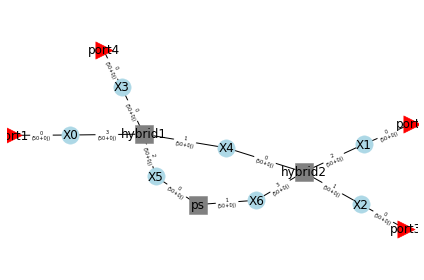

In [16]:
variable_coupler_circuit(0).plot_graph(is_network_labels=True, is_edge_labels=True, 
                                           is_port_labels=True, is_inter_labels=True)

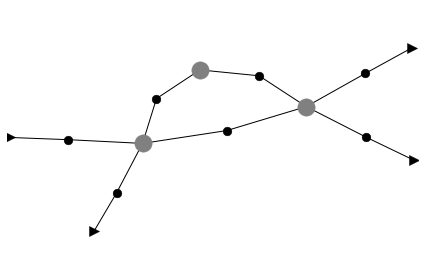

In [17]:
variable_coupler_circuit(0).plot_graph(port_size=100, port_color='k', port_shape='>',
                                inter_shape='.', inter_color='k', network_shape='o', 
                                 is_node_labels=True, is_edge_labels=False,
                                label_shift_y=0.15)

In [18]:
# Testing that both approaches lead to the identical result
angle = np.random.randint(0, 180)
np.testing.assert_array_almost_equal(variable_coupler(angle).s, 
                                     variable_coupler_from_circuit(angle).s, decimal=6)

In [19]:
phases = np.arange(0, 360)
exc = r_[0,0,1,0]

C = []
for phase in phases:
    vc = variable_coupler_from_circuit(phase)
    C.append(vc.s @ exc)  

C = np.array(C)

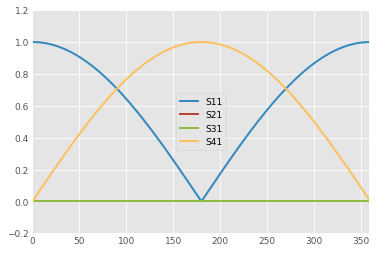

In [20]:
plot(phases, np.abs(C.squeeze()), lw=2)

legend(('S11', 'S21', 'S31', 'S41'))

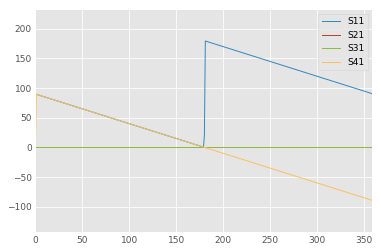

In [21]:
plot(phases, 180/pi*np.angle(C.squeeze()))
legend(('S11', 'S21', 'S31', 'S41'))

## Resonant Ring

![Resonant Ring](Figures/Resonant_Circuit.png)

In [22]:
def resonant_ring(phase1, phase2, attenuation=None):
    vc = variable_coupler(phase1)
    _temp = rf.connect(vc, 3, phase_shifter(phase2), 0)
    _temp = rf.innerconnect(_temp, 2, 3)
    return _temp

In [23]:
phases = np.linspace(0, 180, 10)
P1, P2 = meshgrid(phases, phases)
B = np.zeros((len(P1), len(P1), 2), dtype='complex')

for (id1, p1) in ndenumerate(P1):
    for (id2, p2) in ndenumerate(P2):
        B[id1, id2] = resonant_ring(p1, p2).s @ r_[1,0]

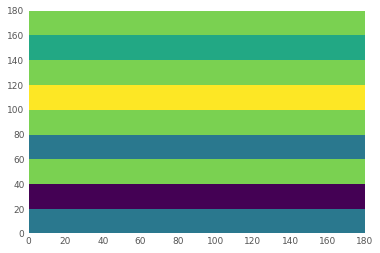

In [24]:
pcolor(P1, P2, np.abs(B[:,:,1]))